In [1]:
import json
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
def plot_acc_loss(hist):
    # Accuracy and loss graphs
    plt.figure()
    plt.plot(hist.history['val_acc'], label='val_acc')
    plt.plot(hist.history['acc'], label='acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.plot(hist.history['loss'], label='loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss value')
    plt.legend()
    plt.show()

In [3]:
class Evaluate:
    def __init__(self, data_dir, predict_folds, labels):
        self.data_dir = data_dir
        self.predict_folds = predict_folds
        self.eval_x = {}
        self.eval_y = {}
        self.pred_y = []
        self.id = {}
        self.labels = labels
        
        self.score = 0
        self.total = 0
        self.confusion = np.zeros((10,10))
        
        self.probs = np.array([11.452130, 4.912964, 11.452130, 
                               11.452130, 11.452130, 11.452130, 
                               4.283097, 11.452130, 10.639029, 
                               11.452130])
        
        for eval_fold in self.predict_folds:
            self.eval_x[eval_fold], self.eval_y[eval_fold] = load_folds(data_dir, [eval_fold])
            
            identifiers_file = os.path.join(data_dir, 'fold' + str(eval_fold) + '_id.json')

            with open(identifiers_file, 'r') as fp:
                self.id[eval_fold] = json.load(fp)
                
    def plot_confusion(self, normalize=None):
        plt.figure(figsize=(8,6))
        if normalize == 'precision':
            confmat = [self.confusion[i]/sum(self.confusion)[i] for i in range(len(self.confusion))]
        elif normalize == 'recall':
            confmat = [self.confusion[i]/sum(self.confusion.T)[i] for i in range(len(self.confusion))]

        df = pd.DataFrame(confmat if normalize else self.confusion,
                          index=self.labels,
                          columns=self.labels)

        ax = sns.heatmap(df,
                annot = True,
                fmt = '.2f' if normalize else '.0f')
        ax.set_ylim([len(self.labels),0])
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion matrix')
        plt.show()
            
    def plot_distribution(self):
        ax = sns.barplot(self.labels, sum(self.confusion.T))
        ax.set_xticklabels(self.labels, rotation=45, horizontalalignment='right')
        plt.show()
    
    def evaluate(self, model, resultForEachFolder=False, confMatForEachFolder=False):
        self.score = 0
        self.total = 0
        self.confusion = np.zeros((10,10))        
        
        for eval_fold in self.predict_folds:
            fold_score = 0
            fold_total = 0
            fold_confusion = np.zeros((10,10))
            
            pred_y = model.predict(self.eval_x[eval_fold])
            pred_y = pred_y * self.probs
            
            for i, wavfile in enumerate(self.id[eval_fold]):
                # At start, initiate first index
                if i == 0:
                    first_idx = 0
                # Continue from index of the last prev .wav feature
                else:
                    first_idx = last_idx

                # Parse last index info from .json
                last_idx = self.id[eval_fold][wavfile]

                # Predict
                prediction = pred_y[first_idx:last_idx].mean(axis=0).argmax()
                label = self.eval_y[eval_fold][first_idx].argmax()

                # Iterate correct prediction count
                if prediction == label:
                    fold_score += 1

                # Confusion matrix
                fold_confusion[label][prediction] += 1

            # Iterate total file count
            fold_total = i+1

            # Iterate overall scores
            self.total += fold_total
            self.score += fold_score
            self.confusion += fold_confusion
            
            # Print results for each folder
            if resultForEachFolder:
                print('Prediction score for fold{}: {:.3f}% ({} out of {})'
                      .format(eval_fold, 100*fold_score/fold_total, fold_score, fold_total))
            if confMatForEachFolder:
                print('Confusion matrix for fold{}:'.format(eval_fold))
                print(fold_confusion)
                
        # Print results for all folders
        print('Prediction score for folds {}: {:.3f}% ({} out of {})'
                  .format(self.predict_folds, 100*self.score/self.total, self.score, self.total))
        
    def scores(self):
        df = pd.DataFrame(index=self.labels)
        df['precision'] = np.array([self.confusion[i][i] / sum(self.confusion)[i] for i in range(len(self.labels))])
        df['recall'] = np.array([self.confusion[i][i] / sum(self.confusion.T)[i] for i in range(len(self.labels))])
        df['f1'] = df.apply(lambda row: 2 * row.precision * row.recall / (row.precision+row.recall), axis=1)
        return df

In [4]:
def calculate_scores(confmat, labels):
    df = pd.DataFrame(index=labels)
    df['precision'] = np.array([confmat[i][i] / sum(confmat)[i] for i in range(len(labels))])
    df['recall'] = np.array([confmat[i][i] / sum(confmat.T)[i] for i in range(len(labels))])
    df['f1'] = df.apply(lambda row: 2 * row.precision * row.recall / (row.precision+row.recall), axis=1)
    return df

In [5]:
def draw_dist(confmat, labels):
    ax = sns.barplot(labels, sum(confmat.T))
    ax.set_xticklabels(labels, rotation=45, horizontalalignment='right')
    plt.show()

In [6]:
def draw_confmat(confmat, labels, normalize=None):
    plt.figure(figsize=(8,6))
    if normalize == 'precision':
        confmat = [confmat[i]/sum(confmat)[i] for i in range(len(confmat))]
    elif normalize == 'recall':
        confmat = [confmat[i]/sum(confmat.T)[i] for i in range(len(confmat))]
    
    df = pd.DataFrame(confmat,
                      index=labels,
                      columns=labels)
    
    ax = sns.heatmap(df,
            annot = True,
            fmt = '.2f' if normalize else '.0f')
    ax.set_ylim([len(labels),0])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion matrix')
    plt.show()

In [7]:
b = [11.452130, 4.912964, 11.452130, 
                      11.452130, 11.452130, 11.452130, 
                      4.283097, 11.452130, 10.639029, 
                      11.452130]

In [8]:
def evaluate_folder(model, data_dir, predict_folds, resultForEachFolder=False, confMatForEachFolder=False):
    score = 0
    total = 0
    confusion = np.zeros((10,10))
    
    for eval_fold in predict_folds:
        fold_score = 0
        fold_total = 0
        fold_confusion = np.zeros((10,10))
        
        eval_x, eval_y = load_folds(data_dir, [eval_fold])
        pred_y = model.predict(eval_x)

        identifiers_file = os.path.join(data_dir, 'fold' + str(eval_fold) + '_id.json')

        with open(identifiers_file, 'r') as fp:
            identifiers = json.load(fp)

        for i, wavfile in enumerate(identifiers):

            # At start, initiate first index
            if i == 0:
                first_idx = 0
            # Continue from index of the last prev .wav feature
            else:
                first_idx = last_idx

            # Parse last index info from .json
            last_idx = identifiers[wavfile]

            # Predict
            prediction = pred_y[first_idx:last_idx].mean(axis=0).argmax()
            label = eval_y[first_idx].argmax()

            # Iterate correct prediction count
            if prediction == label:
                fold_score += 1
            
            # Confusion matrix
            fold_confusion[label][prediction] += 1

        # Iterate total file count
        fold_total = i+1
        
        # Iterate overall scores
        total += fold_total
        score += fold_score
        confusion += fold_confusion
        
        # Print results for each folder
        if resultForEachFolder:
            print('Prediction score for fold{}: {:.3f}% ({} out of {})'
                  .format(eval_fold, fold_score/fold_total, fold_score, fold_total))
        if confMatForEachFolder:
            print('Confusion matrix for fold{}:'.format(eval_fold))
            print(fold_confusion)
    
    # Print results for all folders
    print('Prediction score for folds {}: {:.3f}% ({} out of {})'
              .format(predict_folds, fold_score/fold_total, fold_score, fold_total))
    print('Confusion matrix for folds {}:'.format(predict_folds))
    print(confusion)
    
    return confusion

In [90]:
import pandas as pd
df = pd.read_csv('./UrbanSound8K/metadata/UrbanSound8K.csv')
df.head(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [101]:
df = df[['slice_file_name', 'fold' ,'classID', 'class']][data['end']-data['start'] >= 0.0 ][df['fold'] >= 7]


C:\Users\ASELSAN\anaconda3\envs\hintern\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [103]:
df['path'] = 'fold' + df['fold'].astype('str') + '/' + df['slice_file_name'].astype('str')
df.head(4)

,slice_file_name,fold,classID,class,path
9,100648-1-0-0.wav,10,1,car_horn,fold10/100648-1-0-0.wav
10,100648-1-1-0.wav,10,1,car_horn,fold10/100648-1-1-0.wav
11,100648-1-2-0.wav,10,1,car_horn,fold10/100648-1-2-0.wav
12,100648-1-3-0.wav,10,1,car_horn,fold10/100648-1-3-0.wav


In [119]:
arr = [[ 80  ,25  ,24  , 2  ,32  ,45   ,9  ,12   ,5  ,66],
     [  0 , 25  , 8  , 1  ,11,   2   ,1 ,  1  , 0   ,6],
     [ 10  , 3 ,155  ,51   ,0 , 18   ,0  , 4  ,31  ,28],
     [ 12  , 1  ,33 ,168  , 4  , 4   ,2   ,6  , 9  ,20],
     [  3  ,15  , 7  , 9 ,163  , 2   ,2  ,51  ,12  ,25],
     [ 66  , 1   ,7   ,7 ,  9  ,83   ,0  ,65  ,21   ,8],
     [  0  , 0  , 2   ,1 ,  1  , 0  ,63  , 1  , 0   ,0],
     [  0  , 1 ,  0   ,0 , 48  , 0  , 0 ,195 ,  0   ,8],
     [  3  , 3,  35   ,9 , 10  , 3 ,  0  , 1, 171  ,10],
     [ 11  , 5,  36  ,15 ,  7  , 3,   1   ,5,  15 ,202]]
    

<AxesSubplot:>

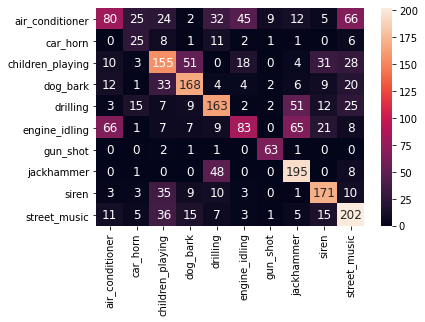

In [142]:
import matplotlib as plt
from matplotlib import figure
index = ["air_conditioner","car_horn","children_playing","dog_bark","drilling","engine_idling","gun_shot","jackhammer","siren","street_music"]
columns=["air_conditioner","car_horn","children_playing","dog_bark","drilling","engine_idling","gun_shot","jackhammer","siren","street_music"]
import seaborn as sn
df_cm = pd.DataFrame(arr, index = [i for i in index],
                  columns = [i for i in columns])
figure.Figure(figsize = (1025,1025))
sn.heatmap(df_cm, annot=True,fmt=".0f",annot_kws={'size':12})

In [127]:
#toplam dogru 1305
#dogru bilme oranı:  0.5588865096359743

In [129]:
#her bir frame ayrı ayrı predict edildikten sonra
arr2= [[ 85,  30,  23,   1,  31,  43,   4,  15,   2,  66],
 [  0,  57,   9,   4,  12,   2,   0,   2,   0,   9],
 [ 18,   2, 189,  36,   0,  10,   0,   2,  21,  22],
 [ 14,   3,  46, 205,   6,   5,   0,   7,   0,  14],
 [  7,  16,  14,   7, 179,   1,   2,  52,   9,  13],
 [ 71,   0,  12,   7,   8,  90,   0,  59,  19,   4],
 [  1,   1,   4,   6,   1,   0,  80,   0,   0,   0],
 [  0,   2,   2,   1,  45,   1,   2, 198,   0,   5],
 [  7,   7,  40,   6,   4,   0,   0,   0, 175,   6],
 [  9,   2,  47,   8,   5,   0,   0,   4,  15, 210],]

<AxesSubplot:>

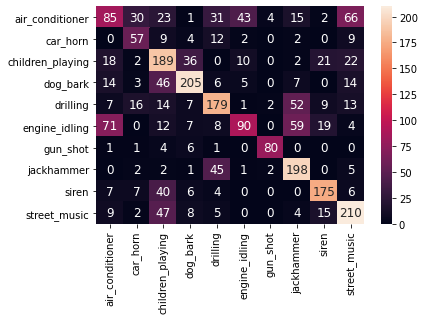

In [141]:
import matplotlib as plt
from matplotlib import figure
index = ["air_conditioner","car_horn","children_playing","dog_bark","drilling","engine_idling","gun_shot","jackhammer","siren","street_music"]
columns=["air_conditioner","car_horn","children_playing","dog_bark","drilling","engine_idling","gun_shot","jackhammer","siren","street_music"]
import seaborn as sn
df_cm = pd.DataFrame(arr2, index = [i for i in index],
                  columns = [i for i in columns])
figure.Figure(figsize = (1025,1025))
sn.heatmap(df_cm, annot=True,fmt=".0f",annot_kws={'size':12})


#total sample: 2459
#dogru 1468
#dogru bilme oranı:  0.5969906466043107

In [133]:
#test overlap yaparken prediction yapıldı
arr3=[[ 601,  158,  147,   31, 217,  300,   72,   78,   47,  449],
[   1 , 164 ,  49,    8,   59,    8,    1,    5,    5,   51],
[  55 ,  15 ,1085,  335,   19,   77,    8,   28,  189,  226],
[  71 ,  22 , 225, 1036,   49,   37,   22,   63,   60,  109],
[  34 ,  82 ,  84,   65,  997,   26,   13,  383,   67,  143],
[ 448 ,   6 ,  64,   54,   52,  607,    0,  401,  155,   65],
[  11 ,   1 ,  17,   53,    7,    0,  202,    1,   11,    4],
[   2 ,   6 ,   8,    6,  302,    5,    9, 1297,    0,   35],
[  41 ,  21 , 222,   69,   54,   11,    0,   12, 1183,   64],
[  84 ,  17 , 273,   68,   55,   12,    8,   41,  100, 1442]]

<AxesSubplot:>

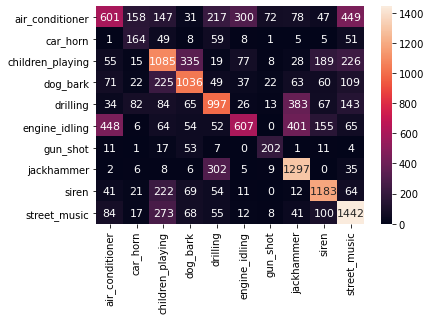

In [148]:
import matplotlib as plt
from matplotlib import figure
index = ["air_conditioner","car_horn","children_playing","dog_bark","drilling","engine_idling","gun_shot","jackhammer","siren","street_music"]
columns=["air_conditioner","car_horn","children_playing","dog_bark","drilling","engine_idling","gun_shot","jackhammer","siren","street_music"]
import seaborn as sn
df_cm = pd.DataFrame(arr3, index = [i for i in index],
                  columns = [i for i in columns])
figure.Figure(figsize = (1025,1025))
sn.heatmap(df_cm, annot=True,fmt=".0f",annot_kws={'size':11})

#dogru 8614
#total: 15.664
#dogru bilme oranı:  0.5492921821196276

In [149]:
arr4 =[[ 84,  29,  17,   1, 29,  46,   7 , 13,   5 , 69],
[  1 , 55 ,  9,   4 , 12,   2,   0 ,  1,   1 , 10],
[ 15 ,  2 ,195,  31 ,  0,   9,   1 ,  2,  22 , 23],
[ 10 ,  4 , 40, 209 ,  6,   6,   0 , 10,   1 , 14],
[  2 , 14 , 18,   7, 172,   4,   2 , 54,   8 , 19],
[ 69 ,  0 , 12,   5,   9,  88,   0 , 59,  24   ,4],
[  3 ,  1 ,  3,  11,   0,   0,  75 ,  0,   0   ,0],
[  0 ,  1 ,  1,   1,  43,   1,   0 ,202,   0  , 7],
[  5 ,  5 , 41,   8,   5,   0,   0 ,  0, 174 ,  7],
[ 10 ,  0 , 40,   4,   4,   0,  0,   4 , 14, 224]]

'\ntrue positive:  75\ntrue negative:  2356\nfalse positive:  10\nfalse negative:  18\nprecision:  0.8823529411764706\nrecall:  0.8064516129032258\nf1 score:  0.8426966292134831\n'

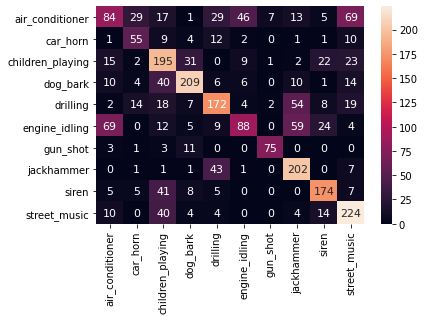

In [151]:
import matplotlib as plt
from matplotlib import figure
index = ["air_conditioner","car_horn","children_playing","dog_bark","drilling","engine_idling","gun_shot","jackhammer","siren","street_music"]
columns=["air_conditioner","car_horn","children_playing","dog_bark","drilling","engine_idling","gun_shot","jackhammer","siren","street_music"]
import seaborn as sn
df_cm = pd.DataFrame(arr4, index = [i for i in index],
                  columns = [i for i in columns])
figure.Figure(figsize = (1025,1025))
sn.heatmap(df_cm, annot=True,fmt=".0f",annot_kws={'size':11})

#dogru 1478
#total sample: 2460
#dogru bilme oranı:  0.6010573403822692
"""
----
class: 0 --- precision: 0.422111
class: 0 --- recall 0.280000:
class: 0 --- f1 skor 0.336673:
class: 1 --- precision: 0.495495
class: 1 --- recall 0.578947:
class: 1 --- f1 skor 0.533981:
class: 2 --- precision: 0.518617
class: 2 --- recall 0.650000:
class: 2 --- f1 skor 0.576923:
class: 3 --- precision: 0.743772
class: 3 --- recall 0.696667:
class: 3 --- f1 skor 0.719449:
class: 4 --- precision: 0.614286
class: 4 --- recall 0.573333:
class: 4 --- f1 skor 0.593103:
class: 5 --- precision: 0.564103
class: 5 --- recall 0.325926:
class: 5 --- f1 skor 0.413146:
---gun shot---
class: 6 --- precision: 0.882353
class: 6 --- recall 0.806452:
class: 6 --- f1 skor 0.842697:

class: 7 --- precision: 0.585507
class: 7 --- recall 0.789062:
class: 7 --- f1 skor 0.672213:
class: 8 --- precision: 0.698795
class: 8 --- recall 0.710204:
class: 8 --- f1 skor 0.704453:
class: 9 --- precision: 0.594164
class: 9 --- recall 0.746667:
class: 9 --- f1 skor 0.661743:
"""

In [152]:
arr5= [[ 58,  18,  51,  14,   3,  59,  30,   1,   6,  60],
 [  1,  52,   6,   3,   9,   5,   1,   1,   1,  16],
 [ 15,   2, 194,  41,   1,   7,   0,   1,  14,  25],
 [ 12,   3,  38, 225,   1,   7,   0,   3,   2,   9],
 [  3,  12,  12,  14, 159,   5,   0,  51,  14,  30],
 [ 38,   2,  16,   5,  34, 157,   0,   6,   4,   8],
 [  2,   0,   4,  16,   0,   1,  67,   0,   2,   1],
 [  0,   0,   3,   0,  43,   0,   0, 200,   0,  10],
 [  2,   6,  39,   9,   2,   0,   0,   0, 179,   8],
 [  6,   1,  48,   6,   4,   2,   0,   2,  16 ,215]]

'\nclass: 0 --- precision: 0.423358\nclass: 0 --- recall 0.193333:\nclass: 0 --- f1 skor 0.265446:\nclass: 1 --- precision: 0.541667\nclass: 1 --- recall 0.547368:\nclass: 1 --- f1 skor 0.544503:\nclass: 2 --- precision: 0.472019\nclass: 2 --- recall 0.646667:\nclass: 2 --- f1 skor 0.545710:\nclass: 3 --- precision: 0.675676\nclass: 3 --- recall 0.750000:\nclass: 3 --- f1 skor 0.710900:\nclass: 4 --- precision: 0.621094\nclass: 4 --- recall 0.530000:\nclass: 4 --- f1 skor 0.571942:\nclass: 5 --- precision: 0.646091\nclass: 5 --- recall 0.581481:\nclass: 5 --- f1 skor 0.612086:\n--------------------------------\nclass: 6 --- precision: 0.683673\nclass: 6 --- recall 0.720430:\nclass: 6 --- f1 skor 0.701571:\n--------------------------------\nclass: 7 --- precision: 0.754717\nclass: 7 --- recall 0.781250:\nclass: 7 --- f1 skor 0.767754:\nclass: 8 --- precision: 0.752101\nclass: 8 --- recall 0.730612:\nclass: 8 --- f1 skor 0.741201:\nclass: 9 --- precision: 0.562827\nclass: 9 --- recall 0.

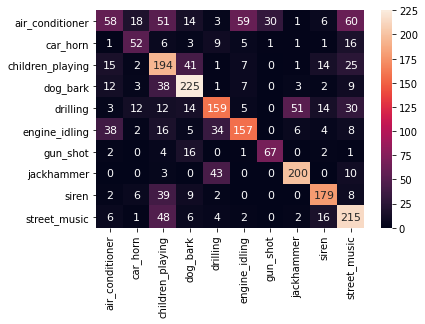

In [154]:
import matplotlib as plt
from matplotlib import figure
index = ["air_conditioner","car_horn","children_playing","dog_bark","drilling","engine_idling","gun_shot","jackhammer","siren","street_music"]
columns=["air_conditioner","car_horn","children_playing","dog_bark","drilling","engine_idling","gun_shot","jackhammer","siren","street_music"]
import seaborn as sn
df_cm = pd.DataFrame(arr5, index = [i for i in index],
                  columns = [i for i in columns])
figure.Figure(figsize = (1025,1025))
sn.heatmap(df_cm, annot=True,fmt=".0f",annot_kws={'size':11})

#model : h-model1.h5
#dogru 1506
#dogru bilme oranı:  0.6124440829605531

"""
class: 0 --- precision: 0.423358
class: 0 --- recall 0.193333:
class: 0 --- f1 skor 0.265446:
class: 1 --- precision: 0.541667
class: 1 --- recall 0.547368:
class: 1 --- f1 skor 0.544503:
class: 2 --- precision: 0.472019
class: 2 --- recall 0.646667:
class: 2 --- f1 skor 0.545710:
class: 3 --- precision: 0.675676
class: 3 --- recall 0.750000:
class: 3 --- f1 skor 0.710900:
class: 4 --- precision: 0.621094
class: 4 --- recall 0.530000:
class: 4 --- f1 skor 0.571942:
class: 5 --- precision: 0.646091
class: 5 --- recall 0.581481:
class: 5 --- f1 skor 0.612086:
--------------------------------
class: 6 --- precision: 0.683673
class: 6 --- recall 0.720430:
class: 6 --- f1 skor 0.701571:
--------------------------------
class: 7 --- precision: 0.754717
class: 7 --- recall 0.781250:
class: 7 --- f1 skor 0.767754:
class: 8 --- precision: 0.752101
class: 8 --- recall 0.730612:
class: 8 --- f1 skor 0.741201:
class: 9 --- precision: 0.562827
class: 9 --- recall 0.716667:
class: 9 --- f1 skor 0.630499:
"""

In [175]:

#model checkpoint yapıldıkta sonra--> 97.epoch da mex val_accuracy
#dogru 1480
#dogru bilme oranı:  0.601870679137861

arr6=[[ 74,  11,  31,  12,  15,  27,  27,   6,  25,  72],
     [  0,  70,   3,   2,   2,   0,   0,   0,   3,  15],
     [ 13,   1, 210,  35,   0,   9,   2,   0,  10,  20],
     [ 13,   4,  49, 215,   2,   4,   0,   2,   1,  10],
     [ 11,  17,  21,  15, 158,   2,   1,  41,   3,  31],
     [ 43,   4,  38,   2,   4, 121,   0,  36,  12,  10],
     [  1,   0,   5,  18,   0,   0,  69,   0,   0,   0],
     [  5,   1,   4,   2,  50,   0,   0, 190,   0,   4],
     [  4,   0,  43,  30,   3,   1,   0,   0, 158,   6],
     [ 11,   3,  49,   0,   9,   0,   3,   0,  10, 215]]

"""
class: 0 --- precision: 0.422857
class: 0 --- recall 0.246667:
class: 0 --- f1 skor 0.311579:
class: 1 --- precision: 0.630631
class: 1 --- recall 0.736842:
class: 1 --- f1 skor 0.679612:
class: 2 --- precision: 0.463576
class: 2 --- recall 0.700000:
class: 2 --- f1 skor 0.557769:
class: 3 --- precision: 0.649547
class: 3 --- recall 0.716667:
class: 3 --- f1 skor 0.681458:
class: 4 --- precision: 0.650206
class: 4 --- recall 0.526667:
class: 4 --- f1 skor 0.581952:
class: 5 --- precision: 0.737805
class: 5 --- recall 0.448148:
class: 5 --- f1 skor 0.557604:
class: 6 --- precision: 0.676471
class: 6 --- recall 0.741935:
class: 6 --- f1 skor 0.707692:
class: 7 --- precision: 0.690909
class: 7 --- recall 0.742188:
class: 7 --- f1 skor 0.715631:
class: 8 --- precision: 0.711712
class: 8 --- recall 0.644898:
class: 8 --- f1 skor 0.676660:
class: 9 --- precision: 0.561358
class: 9 --- recall 0.716667:
class: 9 --- f1 skor 0.629575:
"""


'\nclass: 0 --- precision: 0.422857\nclass: 0 --- recall 0.246667:\nclass: 0 --- f1 skor 0.311579:\nclass: 1 --- precision: 0.630631\nclass: 1 --- recall 0.736842:\nclass: 1 --- f1 skor 0.679612:\nclass: 2 --- precision: 0.463576\nclass: 2 --- recall 0.700000:\nclass: 2 --- f1 skor 0.557769:\nclass: 3 --- precision: 0.649547\nclass: 3 --- recall 0.716667:\nclass: 3 --- f1 skor 0.681458:\nclass: 4 --- precision: 0.650206\nclass: 4 --- recall 0.526667:\nclass: 4 --- f1 skor 0.581952:\nclass: 5 --- precision: 0.737805\nclass: 5 --- recall 0.448148:\nclass: 5 --- f1 skor 0.557604:\nclass: 6 --- precision: 0.676471\nclass: 6 --- recall 0.741935:\nclass: 6 --- f1 skor 0.707692:\nclass: 7 --- precision: 0.690909\nclass: 7 --- recall 0.742188:\nclass: 7 --- f1 skor 0.715631:\nclass: 8 --- precision: 0.711712\nclass: 8 --- recall 0.644898:\nclass: 8 --- f1 skor 0.676660:\nclass: 9 --- precision: 0.561358\nclass: 9 --- recall 0.716667:\nclass: 9 --- f1 skor 0.629575:\n'

<AxesSubplot:>

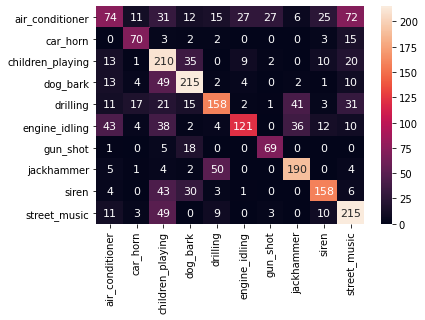

In [181]:
import matplotlib as plt
from matplotlib import figure
index = ["air_conditioner","car_horn","children_playing","dog_bark","drilling","engine_idling","gun_shot","jackhammer","siren","street_music"]
columns=["air_conditioner","car_horn","children_playing","dog_bark","drilling","engine_idling","gun_shot","jackhammer","siren","street_music"]
import seaborn as sn
df_cm = pd.DataFrame(arr6, index = [i for i in index],
                  columns = [i for i in columns])
figure.Figure(figsize = (1025,1025))
sn.heatmap(df_cm, annot=True,fmt=".0f",annot_kws={'size':11})

In [166]:
#fold7 dahil edildi ve train_split yapıldı.
#model adı: weights-improvement-67-0.92.hdf5

arr7=[[ 92,  16 , 23,  26 , 27,  20,  19,   0  , 1,  76],
     [  1,  70 ,  5 ,  3   ,0 ,  2,   0 ,  0  , 1,  13],
     [ 15,   3 ,189  ,45   ,0  , 7 ,  1 ,  0  ,12 , 28],
     [ 13,   3  ,35 ,214  , 1 ,  3,   5,   0 ,  5 , 21],
     [  0 , 12  , 7 ,  6 ,187 ,  0,   1,  38 , 14  ,35],
     [ 30 ,  0  ,27,   8,   0, 152,   0,  27 , 21  , 5],
     [  1 ,  0   ,5 ,  7   ,1 ,  0,  79,   0  , 0  , 0],
     [  3 ,  0  , 6 ,  0  ,80  , 0,   1, 166  , 0  , 0],
     [  2 ,  2 , 42  , 7 ,  9  , 1,   5,   0 ,171  , 6],
     [  3 ,  0,  48  , 3,   4  , 3,   0,   2,   7 ,230]]

'\nclass: 0 --- precision: 0.575000\nclass: 0 --- recall 0.306667:\nclass: 0 --- f1 skor 0.400000:\nclass: 1 --- precision: 0.660377\nclass: 1 --- recall 0.736842:\nclass: 1 --- f1 skor 0.696517:\nclass: 2 --- precision: 0.488372\nclass: 2 --- recall 0.630000:\nclass: 2 --- f1 skor 0.550218:\nclass: 3 --- precision: 0.670846\nclass: 3 --- recall 0.713333:\nclass: 3 --- f1 skor 0.691438:\nclass: 4 --- precision: 0.605178\nclass: 4 --- recall 0.623333:\nclass: 4 --- f1 skor 0.614122:\nclass: 5 --- precision: 0.808511\nclass: 5 --- recall 0.562963:\nclass: 5 --- f1 skor 0.663755:\nclass: 6 --- precision: 0.711712\nclass: 6 --- recall 0.849462:\nclass: 6 --- f1 skor 0.774510:\nclass: 7 --- precision: 0.712446\nclass: 7 --- recall 0.648438:\nclass: 7 --- f1 skor 0.678937:\nclass: 8 --- precision: 0.737069\nclass: 8 --- recall 0.697959:\nclass: 8 --- f1 skor 0.716981:\nclass: 9 --- precision: 0.555556\nclass: 9 --- recall 0.766667:\nclass: 9 --- f1 skor 0.644258:\n'

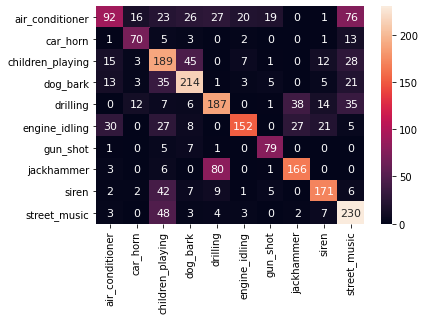

In [170]:
import matplotlib as plt
from matplotlib import figure
index = ["air_conditioner","car_horn","children_playing","dog_bark","drilling","engine_idling","gun_shot","jackhammer","siren","street_music"]
columns=["air_conditioner","car_horn","children_playing","dog_bark","drilling","engine_idling","gun_shot","jackhammer","siren","street_music"]
import seaborn as sn
df_cm = pd.DataFrame(arr7, index = [i for i in index],
                  columns = [i for i in columns])
figure.Figure(figsize = (1025,1025))
sn.heatmap(df_cm, annot=True,fmt=".0f",annot_kws={'size':11})
"""
class: 0 --- precision: 0.575000
class: 0 --- recall 0.306667:
class: 0 --- f1 skor 0.400000:
class: 1 --- precision: 0.660377
class: 1 --- recall 0.736842:
class: 1 --- f1 skor 0.696517:
class: 2 --- precision: 0.488372
class: 2 --- recall 0.630000:
class: 2 --- f1 skor 0.550218:
class: 3 --- precision: 0.670846
class: 3 --- recall 0.713333:
class: 3 --- f1 skor 0.691438:
class: 4 --- precision: 0.605178
class: 4 --- recall 0.623333:
class: 4 --- f1 skor 0.614122:
class: 5 --- precision: 0.808511
class: 5 --- recall 0.562963:
class: 5 --- f1 skor 0.663755:
class: 6 --- precision: 0.711712
class: 6 --- recall 0.849462:
class: 6 --- f1 skor 0.774510:
class: 7 --- precision: 0.712446
class: 7 --- recall 0.648438:
class: 7 --- f1 skor 0.678937:
class: 8 --- precision: 0.737069
class: 8 --- recall 0.697959:
class: 8 --- f1 skor 0.716981:
class: 9 --- precision: 0.555556
class: 9 --- recall 0.766667:
class: 9 --- f1 skor 0.644258:
"""

In [185]:
#dogru 1424
#dogru bilme oranı:  0.5790971939812932
#MODEL : h/02_10modelcallback3/weights-improvement-10-0.58.hdf5
arr8= [[101,   5,  27,   1,  21 , 17 , 27  , 7 , 39,  55],
 [  5,  46,  10,   8,   2 ,  1  , 1  , 2 ,  3,  17],
 [ 21,  0 ,170 , 64 ,  0  , 7   ,3   ,1  ,21  ,13],
 [ 11,   0,  43, 203,   7,   5 ,  1  , 3 , 15 , 12],
 [  7,  13,  17,   4, 183,   0 ,  0  ,35 , 17 , 24],
 [ 26,  10,  23,  14,  20,  92 ,  2  ,60 , 18 ,  5],
 [  0,  0 ,  8 , 23 ,  0 ,  0  ,61   ,0   ,0  , 1],
 [  1,  0 ,  4 ,  0 , 57 ,  0  , 0 ,190  , 0  , 4],
 [  2,   0,  45,  22,   2,   1 ,  0   ,0 ,173 ,  0],
 [ 11,   1,  42,   2,   9,   1 ,  2 ,  7  ,20 ,205]]

#class: 0 --- precision: 0.545946*****class: 0 --- recall 0.336667:*******class: 0 --- f1 skor 0.416495:
#class: 1 --- precision: 0.613333class: 1 --- recall 0.484211:class: 1 --- f1 skor 0.541176:
#class: 2 --- precision: 0.437018class: 2 --- recall 0.566667:class: 2 --- f1 skor 0.493469:
#class: 3 --- precision: 0.595308class: 3 --- recall 0.676667:class: 3 --- f1 skor 0.633385:
#class: 4 --- precision: 0.607973class: 4 --- recall 0.610000:class: 4 --- f1 skor 0.608985:
#class: 5 --- precision: 0.741935class: 5 --- recall 0.340741:class: 5 --- f1 skor 0.467005:

#class: 6 --- precision: 0.628866   class: 6 --- recall 0.655914:  class: 6 --- f1 skor 0.642105: (GUNSHOT)

#class: 7 --- precision: 0.622951class: 7 --- recall 0.742188:class: 7 --- f1 skor 0.677362:
#class: 8 --- precision: 0.565359class: 8 --- recall 0.706122:class: 8 --- f1 skor 0.627949:
#class: 9 --- precision: 0.610119class: 9 --- recall 0.683333:class: 9 --- f1 skor 0.644654:


<AxesSubplot:>

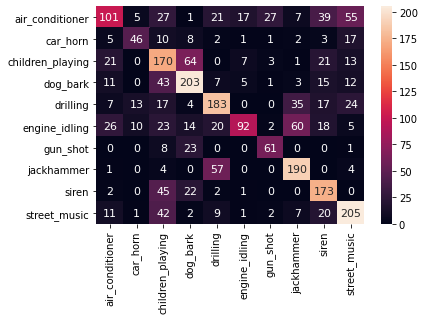

In [186]:
import matplotlib as plt
from matplotlib import figure
index = ["air_conditioner","car_horn","children_playing","dog_bark","drilling","engine_idling","gun_shot","jackhammer","siren","street_music"]
columns=["air_conditioner","car_horn","children_playing","dog_bark","drilling","engine_idling","gun_shot","jackhammer","siren","street_music"]
import seaborn as sn
df_cm = pd.DataFrame(arr8, index = [i for i in index],
                  columns = [i for i in columns])
figure.Figure(figsize = (1025,1025))
sn.heatmap(df_cm, annot=True,fmt=".0f",annot_kws={'size':11})